# Frank-Wolfe method (and variants) applied to SVM
## Optimization for data science - Final project

### General procedures

In [1]:
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import math
import time
import scipy.sparse as sp
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Loading the data and splitting the data into training and testing sets

# Reading the datasets
breastCancer_X, breastCancer_y = load_svmlight_file('C:/Camilo/Estudio/Padova/Optimization for Data Science/ODS-Final-project/Datasets/breast-cancer_scale.txt')
phishing_X, phishing_y = load_svmlight_file('C:/Camilo/Estudio/Padova/Optimization for Data Science/ODS-Final-project/Datasets/phishing.txt')
skin_X, skin_y = load_svmlight_file('C:/Camilo/Estudio/Padova/Optimization for Data Science/ODS-Final-project/Datasets/skin_nonskin.txt')

# breastCancer has a column that corresponds to the id
breastCancer_X=breastCancer_X[:, 1:]

# Adding an offset term to add flexibility to the models.
# Following the guidelines SVM-Lasso paper, the offset is added as "a fixed value
# of one as the last coordinate to each of the datapoints Xi"
offset_term = sp.csr_matrix(np.ones((breastCancer_X.shape[0], 1)))
breastCancer_X = sp.hstack((breastCancer_X,offset_term))

offset_term = sp.csr_matrix(np.ones((phishing_X.shape[0], 1)))
phishing_X = sp.hstack((phishing_X,offset_term))

offset_term = sp.csr_matrix(np.ones((skin_X.shape[0], 1)))
skin_X = sp.hstack((skin_X,offset_term))

# The labels where not {-1,1} (they were {2,4}, {0,1} and {1,2}), so we convert the labels to -1 and 1
# Function to convert labels to -1 and 1
def convert_labels(y):
    unique_values, counts = np.unique(y, return_counts=True)
    negative_label = unique_values[np.argmin(counts)]
    positive_label = unique_values[np.argmax(counts)]
    return np.where(y == negative_label, -1, 1)

breastCancer_y = convert_labels(breastCancer_y)
phishing_y = convert_labels(phishing_y)
skin_y = convert_labels(skin_y)

print('Unique count breastCancer:', np.unique(breastCancer_y,return_counts=True))
print('Unique count phishing:', np.unique(phishing_y,return_counts=True))
print('Unique count skin:', np.unique(skin_y,return_counts=True))


# Splitting the data into training and testing sets 
breastCancer_X_train, breastCancer_X_test, breastCancer_y_train, breastCancer_y_test = train_test_split(breastCancer_X, breastCancer_y,
                                                                                                        test_size=0.2, random_state=6)
phishing_X_train, phishing_X_test, phishing_y_train, phishing_y_test = train_test_split(phishing_X, phishing_y, 
                                                                                        test_size=0.2, random_state=6)
skin_X_train, skin_X_test, skin_y_train, skin_y_test = train_test_split(skin_X, skin_y, 
                                                                        test_size=0.2, random_state=6)

# Printing the shapes of the training and testing sets for each dataset
print('\nBreast Cancer Dataset:')
print('Training Data Shape:', breastCancer_X_train.shape)
print('Testing Data Shape:', breastCancer_X_test.shape)

print('\nPhishing Dataset:')
print('Training Data Shape:', phishing_X_train.shape)
print('Testing Data Shape:', phishing_X_test.shape)

print('\nSkin Dataset:')
print('Training Data Shape:', skin_X_train.shape)
print('Testing Data Shape:', skin_X_test.shape)

Unique count breastCancer: (array([-1,  1]), array([239, 444], dtype=int64))
Unique count phishing: (array([-1,  1]), array([4898, 6157], dtype=int64))
Unique count skin: (array([-1,  1]), array([ 50859, 194198], dtype=int64))

Breast Cancer Dataset:
Training Data Shape: (546, 10)
Testing Data Shape: (137, 10)

Phishing Dataset:
Training Data Shape: (8844, 69)
Testing Data Shape: (2211, 69)

Skin Dataset:
Training Data Shape: (196045, 4)
Testing Data Shape: (49012, 4)


In [3]:
# Definition of the parameters.

# Definition of the C regularization parameter, the gamma and the delta for the armijo rule step-size
C=1
gamma = 10**-2
delta = 0.5

# Definition of the parameters to stop the algorithms
maxIterations = 50000
maxTime = 300
gapTolerance = 10**-3

# Strings to identify the methods as they are used repeatedly in the implementation
stringFW = 'FW'
stringAwayFW = 'AwayFW'
stringPairFW = 'PairFW'

stringDimStepSize = 'Diminishing step-size'
stringArmijoStepSize = 'Armijo step-size'

stringBreastCancer = 'Breast cancer'
stringPhishing = 'Phishing'
stringSkin = 'Skin'

# Definition of a dictionary to store the results for the plots
resultsBreastCancer = {}
resultsPhishing = {}
resultsSkin = {}

### Definition of the dual problem

In [4]:
# Definition and execution of some of the problem characteristics: the objective function, the gradient function and the Hessian

# Definition of the dual problem as a quadratic function. This implies reorganizing the data. 
# According to the SVM-LASSO paper, first we need a Z matrix whose columns crresponds to Zi := yi*Xi. 
# In this case, Xi corresponds to the features of the ith observation (it belongs to R^d)
# The Z matrix will be used to go back to the primal.
# Then, following the paper's notation, we create an A matrix by vertically stacking Z and I_n multiplied by a scalar.
# This is the A that will be used to optimize the ||A*alpha||^2 dual problem stated in the paper.
def A_Z_matrices(X,y):
    Zi_list = []
    n = len(y)
    for i in range(n):
        Zi = y[i]*X[i,:]
        Zi_list.append(Zi)
    Z = sp.vstack(Zi_list).T
    
    I_n =  sp.identity(n)

    A = sp.vstack((Z, (1/math.sqrt(C))*I_n))
    return A, Z

A_breastCancer, Z_breastCancer = A_Z_matrices(breastCancer_X_train, breastCancer_y_train)
A_phishing, Z_phishing = A_Z_matrices(phishing_X_train, phishing_y_train)
A_skin, Z_skin = A_Z_matrices(skin_X_train, skin_y_train)

### Frank-Wolfe implementation

In [5]:
# Definition of a function to implement the original Frank-Wolfe with a diminishing step-size
def frank_wolfe_DS(A, gap_tolerance, max_iter, max_time, resultsDict):
    
    # Initilization of the variables
    timeList = [] 
    iterationsList = []
    gapList = []
    startTime = time.time()
    
    timeSpent = 0
    iterations = 0
    
    # Selection of the starting point as e1.
    # Following the paper's notation,'alpha' will be our 'x' vector (the one that we will update to find the optimum) 
    # To use memory efficiently, we work with sparse matrices (it creates a vector of 0 with a 1 at index 0)
    n = A.shape[1]
    alpha = sp.csr_matrix((np.ones(1), ([0], [0])), shape=(n, 1), dtype=float)
      
    # Iterating until optimality conditions are met or the time or iterations budget are surpassed 
    while(iterations < max_iter and timeSpent < max_time):
        
        # Calculation of the gradient 
        # The complete formula of the gradient is 2 * A.T @ (A @ alpha),
        # but we do the calculation by parts because some computations will be later reused.   
        A_dot_alpha = A @ alpha
        gradient = 2 * A.T @ A_dot_alpha
        
        # Solution of FW problem
        # We obtain the vertex corresponding to the min component of the gradient and set alphaHat to that point
        # To use memory efficiently, we work with sparse matrices (it creates a vector of 0 with a 1 at index iHat)
        iHat = np.argmin(gradient)
        alphaHat = sp.csr_matrix((np.ones(1), ([iHat], [0])), shape=(n, 1), dtype=float)
        
        # Direction calculation
        d = alphaHat - alpha
        
        # Checking optimality conditions to stop
        # Since we are working with sparse matrices, we need to extract the value that results from the operation
        gap = - gradient.T @ d
        gap = gap[0,0]
        if gap <= gap_tolerance:
            break
            
        # Computing the diminishing step-size
        stepSize = 2/(iterations+2)
        
        # Updating alpha (our 'x' vector)
        alpha = alpha + stepSize*d
        
        # Append of the time, the iterations and the gap (the 'error')
        currentTime = time.time()
        timeSpent = currentTime-startTime
        timeList.append(timeSpent)
        iterationsList.append(iterations)
        gapList.append(gap)
        
        # Updating the iterations counter
        iterations += 1
   
    # We organize the results for the plot and then obtain the resulting objective function.
    # The complete formula is (alpha.T @ A.T) @ (A @ alpha), so we reuse a previous computation
    # Since we are working with sparse matrices, we need to extract the value that results from the operation
    resultsDict[stringFW] = [timeList, iterationsList, gapList, alpha]
    objFunValue = ((alpha.T @ A.T) @ (A @ alpha))[0,0]
    return {'alpha':alpha, 'gap':gap, 'objFunValue':objFunValue}

In [6]:
# Definition of a function to implement the original Frank-Wolfe with with the Armijo rule step-size
def frank_wolfe_AR(A, gap_tolerance, max_iter, max_time, resultsDict):
    
    # Initilization of the variables
    timeList = [] 
    iterationsList = []
    gapList = []
    startTime = time.time()
    
    timeSpent = 0
    iterations = 0
    
    # Selection of the starting point as e1.
    # Following the paper's notation,'alpha' will be our 'x' vector (the one that we will update to find the optimum) 
    # To use memory efficiently, we work with sparse matrices (it creates a vector of 0 with a 1 at index 0)
    n = A.shape[1]
    alpha = sp.csr_matrix((np.ones(1), ([0], [0])), shape=(n, 1), dtype=float)
      
    # Iterating until optimality conditions are met or the time or iterations budget are surpassed
    # We add a flag to check if the Armijo line search is too small (it is not stopping on its own)
    flagArmijoFW = False
    while(iterations < max_iter and timeSpent < max_time and flagArmijoFW == False):
        
        # Calculation of the gradient
        # The complete formula of the gradient is 2 * A.T @ (A @ alpha),
        # but we do the calculation by parts because some computations will be later reused.   
        A_dot_alpha = A @ alpha
        gradient = 2 * A.T @ A_dot_alpha
        
        # Solution of FW problem
        # We obtain the vertex corresponding to the min component of the gradient and set alphaHat to that point
        # To use memory efficiently, we work with sparse matrices (it creates a vector of 0 with a 1 at index iHat)
        iHat = np.argmin(gradient)
        alphaHat = sp.csr_matrix((np.ones(1), ([iHat], [0])), shape=(n, 1), dtype=float)
        
        # Direction calculation
        d = alphaHat - alpha
        
        # Checking optimality conditions to stop
        # We first compute the dot product between the gradient and the direction (it will be reused later)
        # And then the negative of this value is equal to the duality gap.
        # Since we are working with sparse matrices, we need to extract the value that results from the operation
        gradient_dot_d = (gradient.T @ d)[0,0]
        gap = - gradient_dot_d
        if gap <= gap_tolerance:
            break
        
        #-------------------------------------------------------------------------------------------------------
        # Computing the step-size with the Armijo rule.
        # Definition of some parameters for the Armijo rule (m and the starting step-size)
        # We will use the diminishing step-size as the starting value
        stepSize = 2/(iterations+2)
        m = 0
        armijoStop = False

        # Computation of the current objective function for the current iteration
        # The complete formula is (alpha.T @ A.T) @ (A @ alpha), so we reuse a previous computation
        # Since we are working with sparse matrices, we need to extract the value that results from the operation
        f_alpha = ((alpha.T @ A.T) @ A_dot_alpha)[0,0]
        
        # Looping until the armijo inequality is satisfied
        while armijoStop == False:
            stepSize = (delta**m) * stepSize
            otherAlpha = alpha + stepSize*d
            f_otherAlpha = ((otherAlpha.T @ A.T) @ (A @ otherAlpha))[0,0]
            if f_otherAlpha <= f_alpha + gamma*stepSize*gradient_dot_d:
                armijoStop = True
            m += 1
            
            # Checking if the stepSize is too small andit has not stopped. If it is, we stop both the Armijo search and the FW algorithm 
            # Also, we go back one step and discount one iteration of the FW (because we do not apply any updates in that case)
            if armijoStop == False and stepSize <= 1e-20:
                otherAlpha = alpha
                f_otherAlpha = f_alpha
                armijoStop = True
                flagArmijoFW = True
                iterations -= 1
        #-------------------------------------------------------------------------------------------------------
                
        # Updating alpha (our 'x' vector) as the last successful 'alpha' update of the Armijo line search
        alpha = otherAlpha
        
        # Append of the time, the iterations and the gap (the 'error')
        currentTime = time.time()
        timeSpent = currentTime-startTime
        timeList.append(timeSpent)
        iterationsList.append(iterations)
        gapList.append(gap)
        
        # Updating the iterations counter
        iterations += 1
   
    # We organize the results for the plot and then obtain the resulting objective function.
    # We obtain the resulting objective function as the last successful function update of the Armijo line search
    resultsDict[stringFW + '_' + stringArmijoStepSize] = [timeList, iterationsList, gapList, alpha]
    objFunValue = f_otherAlpha
    return {'alpha':alpha, 'gap':gap, 'objFunValue':objFunValue}

In [7]:
# Execution of the Frank-Wolfe (with both types of stepsize) algorithms to minimize the dual problem for the three datasets
outputFW_breastCancer_DS = frank_wolfe_DS(A=A_breastCancer, gap_tolerance=gapTolerance,max_iter=maxIterations,
                                          max_time=maxTime, resultsDict=resultsBreastCancer)
outputFW_breastCancer_AR = frank_wolfe_AR(A=A_breastCancer, gap_tolerance=gapTolerance,max_iter=maxIterations,
                                          max_time=maxTime, resultsDict=resultsBreastCancer)

outputFW_phishing_DS = frank_wolfe_DS(A=A_phishing, gap_tolerance=gapTolerance,max_iter=maxIterations,
                                      max_time=maxTime, resultsDict=resultsPhishing)
outputFW_phishing_AR = frank_wolfe_AR(A=A_phishing, gap_tolerance=gapTolerance,max_iter=maxIterations,
                                      max_time=maxTime, resultsDict=resultsPhishing)                                      
                                      
outputFW_skin_DS = frank_wolfe_DS(A=A_skin, gap_tolerance=gapTolerance,max_iter=maxIterations,
                                  max_time=maxTime, resultsDict=resultsSkin)
outputFW_skin_AR = frank_wolfe_AR(A=A_skin, gap_tolerance=gapTolerance,max_iter=maxIterations,
                                  max_time=maxTime, resultsDict=resultsSkin)

### Away-steps Frank-Wolfe implementation

In [8]:
# Definition of a function to implement the the Away-steps Frank-Wolfe variant
def away_steps_frank_wolfe(A, gap_tolerance, max_iter, max_time, resultsDict):
    
    # Initilization of the variables
    timeList = [] 
    iterationsList = []
    gapList = []
    startTime = time.time()
    
    timeSpent = 0
    iterations = 0
    
    # Selection of the starting point as e1.
    # Following the paper's notation,'alpha' will be our 'x' vector (the one that we will update to find the optimum) 
    # To use memory efficiently, we work with sparse matrices (it creates a vector of 0 with a 1 at index 0)
    n = A.shape[1]
    alpha = sp.csr_matrix((np.ones(1), ([0], [0])), shape=(n, 1), dtype=float)
      
    # Iterating until optimality conditions are met or the time or iterations budget are surpassed
    # We add a flag to check if the Armijo line search is too small (it is not stopping on its own)
    flagArmijoFW = False
    while(iterations <= max_iter and timeSpent < max_time and flagArmijoFW == False):
        
        # Calculation of the gradient
        # The complete formula of the gradient is 2 * A.T @ (A @ alpha),
        # but we do the calculation by parts because some computations will be later reused.   
        A_dot_alpha = A @ alpha
        gradient = 2 * A.T @ A_dot_alpha
        
        # Solution of FW problem
        # We obtain the vertex corresponding to the min component of the gradient and set alphaHat to that point
        # To use memory efficiently, we work with sparse matrices (it creates a vector of 0 with a 1 at index iHatFW)
        iHatFW = np.argmin(gradient)
        alphaHatFW = sp.csr_matrix((np.ones(1), ([iHatFW], [0])), shape=(n, 1), dtype=float)
        
        
        # Solution of Away step problem
        ## First, we find the non-zero indices of alpha (our 'x' vector). These are the currently used vertices of our polytope.
        ## Then, we find the index corresponding to the max component of the gradient
        iNonZero = alpha.nonzero()[0]
        iMaxNonZero = np.argmax(gradient[iNonZero])

        ## Next, we set alphaHat to the vertex corresponding to the index obtained in the previous step
        iHatAS = iNonZero[iMaxNonZero]
        alphaHatAS = sp.csr_matrix((np.ones(1), ([iHatAS], [0])), shape=(n, 1), dtype=float)
        
        
        # Calculation of both directions (the final direction will be chosen later between these two)
        dFW = alphaHatFW - alpha
        dAS = alpha - alphaHatAS

        # Computation of the two dot products (that will be used later)
        # Since we are working with sparse matrices, we need to extract the value that results from the operation
        gradient_dot_d_FW = (gradient.T @ dFW)[0,0]
        gradient_dot_d_AS = (gradient.T @ dAS)[0,0]
        
        # Checking optimality conditions (it takes into account the solution of the FW problem)
        gap = - gradient_dot_d_FW
        if gap <= gap_tolerance:
            break
        
        # Choice of the search direction (FW direction or away direction)
        if gradient_dot_d_FW <= gradient_dot_d_AS:
            d = dFW
            directionDot = gradient_dot_d_FW
            stepSizeBar = 1
        else:
            d = dAS
            directionDot = gradient_dot_d_AS
            
            # Computation of the max step-size for the away direction
            # It is necessary to extract the value since we work with sparse matrices
            alpha_iHatAS = (alpha[iHatAS])[0,0]   
            stepSizeBar = alpha_iHatAS / (1 - alpha_iHatAS)
            
        #-------------------------------------------------------------------------------------------------------
        # Computing the step-size with the Armijo rule.
        # Definition of some parameters for the Armijo rule (m and the starting step-size)
        # We will use the stepsizeBar from the previous step as the starting value
        stepSize = stepSizeBar
        m = 0
        armijoStop = False

        # Computation of the current objective function for the current iteration
        # The complete formula is (alpha.T @ A.T) @ (A @ alpha), so we reuse a previous computation
        # Since we are working with sparse matrices, we need to extract the value that results from the operation
        f_alpha = ((alpha.T @ A.T) @ A_dot_alpha)[0,0]
        
        # Looping until the armijo inequality is satisfied
        while armijoStop == False:
            stepSize = (delta**m) * stepSize
            otherAlpha = alpha + stepSize*d
            f_otherAlpha = ((otherAlpha.T @ A.T) @ (A @ otherAlpha))[0,0]
            if f_otherAlpha <= f_alpha + gamma*stepSize*directionDot:
                armijoStop = True
            m += 1
            
            # Checking if the stepSize is too small andit has not stopped. If it is, we stop both the Armijo search and the FW algorithm 
            # Also, we go back one step and discount one iteration of the FW (because we do not apply any updates in that case)
            if armijoStop == False and stepSize <= 1e-20:
                otherAlpha = alpha
                f_otherAlpha = f_alpha
                armijoStop = True
                flagArmijoFW = True
                iterations -= 1
        #-------------------------------------------------------------------------------------------------------
        
        
        # Updating alpha (our 'x' vector) as the last successful 'alpha' update of the Armijo line search
        alpha = otherAlpha
        
        # Append of the time, the iterations and the gap (the 'error')
        currentTime = time.time()
        timeSpent = currentTime-startTime
        timeList.append(timeSpent)
        iterationsList.append(iterations)
        gapList.append(gap)
        
        # Updating the iterations counter
        iterations += 1
   
    # We organize the results for the plot and then obtain the resulting objective function.
    # We obtain the resulting objective function as the last successful function update of the Armijo line search
    resultsDict[stringAwayFW] = [timeList, iterationsList, gapList, alpha]
    objFunValue = f_otherAlpha
    return {'alpha':alpha, 'gap':gap, 'objFunValue':objFunValue}

In [9]:
# Execution of the Away-steps Frank-Wolfe algorithm to minimize the dual problem for the three datasets
outputASFW_breastCancer = away_steps_frank_wolfe(A=A_breastCancer, gap_tolerance=gapTolerance,max_iter=maxIterations,
                                                 max_time=maxTime, resultsDict=resultsBreastCancer)

outputASFW_phishing = away_steps_frank_wolfe(A=A_phishing, gap_tolerance=gapTolerance,max_iter=maxIterations,
                                             max_time=maxTime, resultsDict=resultsPhishing)

outputASFW_skin = away_steps_frank_wolfe(A=A_skin, gap_tolerance=gapTolerance,max_iter=maxIterations,
                                          max_time=maxTime, resultsDict=resultsSkin)

### Pairwise Frank-Wolfe implementation

In [10]:
# Definition of a function to implement the the Away-steps Frank-Wolfe variant
def pairwise_frank_wolfe(A, gap_tolerance, max_iter, max_time, resultsDict):
    
    # Initilization of the variables
    timeList = [] 
    iterationsList = []
    gapList = []
    startTime = time.time()
    
    timeSpent = 0
    iterations = 0
    
    # Selection of the starting point as e1.
    # Following the paper's notation,'alpha' will be our 'x' vector (the one that we will update to find the optimum) 
    # To use memory efficiently, we work with sparse matrices (it creates a vector of 0 with a 1 at index 0)
    n = A.shape[1]
    alpha = sp.csr_matrix((np.ones(1), ([0], [0])), shape=(n, 1), dtype=float)
      
    # Iterating until optimality conditions are met or the time or iterations budget are surpassed
    # We add a flag to check if the Armijo line search is too small (it is not stopping on its own)
    flagArmijoFW = False
    while(iterations <= max_iter and timeSpent < max_time and flagArmijoFW == False):
        
        # Calculation of the gradient
        # The complete formula of the gradient is 2 * A.T @ (A @ alpha),
        # but we do the calculation by parts because some computations will be later reused.   
        A_dot_alpha = A @ alpha
        gradient = 2 * A.T @ A_dot_alpha
        
        # Solution of FW problem
        # We obtain the vertex corresponding to the min component of the gradient and set alphaHat to that point
        # To use memory efficiently, we work with sparse matrices (it creates a vector of 0 with a 1 at index iHatFW)
        iHatFW = np.argmin(gradient)
        alphaHatFW = sp.csr_matrix((np.ones(1), ([iHatFW], [0])), shape=(n, 1), dtype=float)
        
        
        # Solution of Away step problem
        ## First, we find the non-zero indices of alpha (our 'x' vector). These are the currently used vertices of our polytope.
        ## Then, we find the index corresponding to the max component of the gradient
        iNonZero = alpha.nonzero()[0]
        iMaxNonZero = np.argmax(gradient[iNonZero])

        ## Next, we set alphaHat to the vertex corresponding to the index obtained in the previous step
        iHatAS = iNonZero[iMaxNonZero]
        alphaHatAS = sp.csr_matrix((np.ones(1), ([iHatAS], [0])), shape=(n, 1), dtype=float) 
        
        
        # Checking optimality conditions (it takes into account the solution of the FW problem)
        # Since we are working with sparse matrices, we need to extract the value that results from the operation
        dFW = alphaHatFW - alpha
        gap = - gradient.T @ dFW
        gap = gap[0,0]
        if gap <= gap_tolerance:
            break
            
        # Calculation of the pairwise direction, 
        # Also, for the pairwise direction, we compute the max step-size and 
        # the dot product to be taken as a reference in the Armijo rule procedure and the dot product 
        # It is necessary to extract the value since we work with sparse matrices
        d = alphaHatFW - alphaHatAS
        directionDot = (gradient.T @ d)[0,0]
        stepSizeBar = (alpha[iHatAS])[0,0]
         
        #-------------------------------------------------------------------------------------------------------
        # Computing the step-size with the Armijo rule.
        # Definition of some parameters for the Armijo rule (m and the starting step-size)
        # We will use the stepsizeBar from the previous step as the starting value
        stepSize = stepSizeBar
        m = 0
        armijoStop = False

        # Computation of the current objective function for the current iteration
        # The complete formula is (alpha.T @ A.T) @ (A @ alpha), so we reuse a previous computation
        # Since we are working with sparse matrices, we need to extract the value that results from the operation
        f_alpha = ((alpha.T @ A.T) @ A_dot_alpha)[0,0]
        
        # Looping until the armijo inequality is satisfied
        while armijoStop == False:
            stepSize = (delta**m) * stepSize
            otherAlpha = alpha + stepSize*d
            f_otherAlpha = ((otherAlpha.T @ A.T) @ (A @ otherAlpha))[0,0]
            if f_otherAlpha <= f_alpha + gamma*stepSize*directionDot:
                armijoStop = True
            m += 1
            
            # Checking if the stepSize is too small andit has not stopped. If it is, we stop both the Armijo search and the FW algorithm 
            # Also, we go back one step and discount one iteration of the FW (because we do not apply any updates in that case)
            if armijoStop == False and stepSize <= 1e-20:
                otherAlpha = alpha
                f_otherAlpha = f_alpha
                armijoStop = True
                flagArmijoFW = True
                iterations -= 1
        #-------------------------------------------------------------------------------------------------------
        
        
        # Updating alpha (our 'x' vector) as the last successful 'alpha' update of the Armijo line search
        alpha = otherAlpha
        
        # Append of the time, the iterations and the gap (the 'error')
        currentTime = time.time()
        timeSpent = currentTime-startTime
        timeList.append(timeSpent)
        iterationsList.append(iterations)
        gapList.append(gap)
        
        # Updating the iterations counter
        iterations += 1
   
    # We organize the results for the plot and then obtain the resulting objective function.
    # We obtain the resulting objective function as the last successful function update of the Armijo line search
    resultsDict[stringPairFW] = [timeList, iterationsList, gapList, alpha]
    objFunValue = f_otherAlpha
    return {'alpha':alpha, 'gap':gap, 'objFunValue':objFunValue}

In [11]:
# Execution of the Pairwise Frank-Wolfe algorithm to minimize the dual problem for the three datasets
outputPairFW_breastCancer = pairwise_frank_wolfe(A=A_breastCancer, gap_tolerance=gapTolerance,max_iter=maxIterations,
                                                 max_time=maxTime, resultsDict=resultsBreastCancer)

outputPairFW_phishing = pairwise_frank_wolfe(A=A_phishing, gap_tolerance=gapTolerance,max_iter=maxIterations,
                                             max_time=maxTime, resultsDict=resultsPhishing)

outputPairFW_skin = pairwise_frank_wolfe(A=A_skin, gap_tolerance=gapTolerance,max_iter=maxIterations,
                                         max_time=maxTime, resultsDict=resultsSkin)

### Returning to the primal

In [12]:
# Frank-Wolfe (with both the diminishing step-size and the Armijo rule) 
# Return to the primal

# First, we obtain the W vector as Z*alpha,
# This is possible due to the optimality conditions of the dual problem
wFW_breastCancer_DS = Z_breastCancer @ outputFW_breastCancer_DS['alpha']
wFW_breastCancer_AR = Z_breastCancer @ outputFW_breastCancer_AR['alpha']

wFW_phishing_DS = Z_phishing @ outputFW_phishing_DS['alpha']
wFW_phishing_AR = Z_phishing @ outputFW_phishing_AR['alpha']

wFW_skin_DS = Z_skin @ outputFW_skin_DS['alpha']
wFW_skin_AR = Z_skin @ outputFW_skin_AR['alpha']


# Then we classify the data by taking the sign of (W^T)*Xi (this is the same as multiplying X*w and taking the sign)
# We use the w vector obtained with the training set and get the predictions of the test set
yPred_FW_breastCancer_DS = breastCancer_X_test @ wFW_breastCancer_DS
yPred_FW_breastCancer_DS = np.sign(yPred_FW_breastCancer_DS.toarray().flatten())

yPred_FW_breastCancer_AR = breastCancer_X_test @ wFW_breastCancer_AR
yPred_FW_breastCancer_AR = np.sign(yPred_FW_breastCancer_AR.toarray().flatten())


yPred_FW_phishing_DS = phishing_X_test @ wFW_phishing_DS
yPred_FW_phishing_DS = np.sign(yPred_FW_phishing_DS.toarray().flatten())

yPred_FW_phishing_AR = phishing_X_test @ wFW_phishing_AR
yPred_FW_phishing_AR = np.sign(yPred_FW_phishing_AR.toarray().flatten())


yPred_FW_skin_DS = skin_X_test @ wFW_skin_DS
yPred_FW_skin_DS = np.sign(yPred_FW_skin_DS.toarray().flatten())

yPred_FW_skin_AR = skin_X_test @ wFW_skin_AR
yPred_FW_skin_AR = np.sign(yPred_FW_skin_AR.toarray().flatten())

In [13]:
# Away-steps Frank-Wolfe 
# Return to the primal

# First, we obtain the W vector as Z*alpha,
# This is possible due to the optimality conditions of the dual problem
wASFW_breastCancer = Z_breastCancer @ outputASFW_breastCancer['alpha']
wASFW_phishing = Z_phishing @ outputASFW_phishing['alpha']
wASFW_skin = Z_skin @ outputASFW_skin['alpha']


# Then we classify the data by taking the sign of (W^T)*Xi (this is the same as multiplying X*w and taking the sign)
yPred_ASFW_breastCancer = breastCancer_X_test @ wASFW_breastCancer
yPred_ASFW_breastCancer = np.sign(yPred_ASFW_breastCancer.toarray().flatten())

yPred_ASFW_phishing = phishing_X_test @ wASFW_phishing
yPred_ASFW_phishing = np.sign(yPred_ASFW_phishing.toarray().flatten())

yPred_ASFW_skin = skin_X_test @ wASFW_skin
yPred_ASFW_skin = np.sign(yPred_ASFW_skin.toarray().flatten())

In [14]:
# Pairwise Frank-Wolfe 
# Return to the primal

# First, we obtain the W vector as Z*alpha,
# This is possible due to the optimality conditions of the dual problem
wPairFW_breastCancer = Z_breastCancer @ outputPairFW_breastCancer['alpha']
wPairFW_phishing = Z_phishing @ outputPairFW_phishing['alpha']
wPairFW_skin = Z_skin @ outputPairFW_skin['alpha']


# Then we classify the data by taking the sign of (W^T)*Xi (this is the same as multiplying X*w and taking the sign)
yPred_PairFW_breastCancer = breastCancer_X_test @ wPairFW_breastCancer
yPred_PairFW_breastCancer = np.sign(yPred_PairFW_breastCancer.toarray().flatten())

yPred_PairFW_phishing = phishing_X_test @ wPairFW_phishing
yPred_PairFW_phishing = np.sign(yPred_PairFW_phishing.toarray().flatten())

yPred_PairFW_skin = skin_X_test @ wPairFW_skin
yPred_PairFW_skin = np.sign(yPred_PairFW_skin.toarray().flatten())

### Checking the classification task results

In [15]:
# Getting the overall accuracy and f1 scores (on the test set)

# ----------------------------------------------------------------------------
# Frank-Wolfe (with both diminishing step-size and Armijo rule)
accuracy_FW_breastCancer_DS = accuracy_score(breastCancer_y_test, yPred_FW_breastCancer_DS)
f1Score_FW_breastCancer_DS = f1_score(breastCancer_y_test, yPred_FW_breastCancer_DS)
accuracy_FW_breastCancer_AR = accuracy_score(breastCancer_y_test, yPred_FW_breastCancer_AR)
f1Score_FW_breastCancer_AR = f1_score(breastCancer_y_test, yPred_FW_breastCancer_AR)

accuracy_FW_phishing_DS = accuracy_score(phishing_y_test, yPred_FW_phishing_DS)
f1Score_FW_phishing_DS = f1_score(phishing_y_test, yPred_FW_phishing_DS)
accuracy_FW_phishing_AR = accuracy_score(phishing_y_test, yPred_FW_phishing_AR)
f1Score_FW_phishing_AR = f1_score(phishing_y_test, yPred_FW_phishing_AR)

accuracy_FW_skin_DS = accuracy_score(skin_y_test, yPred_FW_skin_DS)
f1Score_FW_skin_DS = f1_score(skin_y_test, yPred_FW_skin_DS)
accuracy_FW_skin_AR = accuracy_score(skin_y_test, yPred_FW_skin_AR)
f1Score_FW_skin_AR = f1_score(skin_y_test, yPred_FW_skin_AR)

# ----------------------------------------------------------------------------
# Away-steps Frank-Wolfe
accuracy_ASFW_breastCancer = accuracy_score(breastCancer_y_test, yPred_ASFW_breastCancer)
f1Score_ASFW_breastCancer = f1_score(breastCancer_y_test, yPred_ASFW_breastCancer)

accuracy_ASFW_phishing = accuracy_score(phishing_y_test, yPred_ASFW_phishing)
f1Score_ASFW_phishing = f1_score(phishing_y_test, yPred_ASFW_phishing)

accuracy_ASFW_skin = accuracy_score(skin_y_test, yPred_ASFW_skin)
f1Score_ASFW_skin = f1_score(skin_y_test, yPred_ASFW_skin)


# ----------------------------------------------------------------------------
# Pairwise Frank-Wolfe
accuracy_PairFW_breastCancer = accuracy_score(breastCancer_y_test, yPred_PairFW_breastCancer)
f1Score_PairFW_breastCancer = f1_score(breastCancer_y_test, yPred_PairFW_breastCancer)

accuracy_PairFW_phishing = accuracy_score(phishing_y_test, yPred_PairFW_phishing)
f1Score_PairFW_phishing = f1_score(phishing_y_test, yPred_PairFW_phishing)

accuracy_PairFW_skin = accuracy_score(skin_y_test, yPred_PairFW_skin)
f1Score_PairFW_skin = f1_score(skin_y_test, yPred_PairFW_skin)

In [16]:
# Organizing the classification task results in tables for each dataset

# Definition of a function to organize the classification results
def classification_results(datasetName):
    # Creating lists for each of the datasets with the accuracy and f1 scores of each method
    listMethods = ['Frank-Wolfe with DS', 'Frank-Wolfe with AR', 'Away-steps Frank-Wolfe','Pairwise Frank-Wolfe']
    if datasetName == stringBreastCancer:
        listAccuracy = [accuracy_FW_breastCancer_DS, accuracy_FW_breastCancer_AR, 
                        accuracy_ASFW_breastCancer, accuracy_PairFW_breastCancer]
        listf1Score = [f1Score_FW_breastCancer_DS, f1Score_FW_breastCancer_AR,
                       f1Score_ASFW_breastCancer, f1Score_PairFW_breastCancer]
    elif datasetName == stringPhishing:
        listAccuracy = [accuracy_FW_phishing_DS, accuracy_FW_phishing_AR, 
                        accuracy_ASFW_phishing, accuracy_PairFW_phishing]
        listf1Score = [f1Score_FW_phishing_DS, f1Score_FW_phishing_AR,
                       f1Score_ASFW_phishing, f1Score_PairFW_phishing]
    elif datasetName == stringSkin:
        listAccuracy = [accuracy_FW_skin_DS, accuracy_FW_skin_AR, 
                        accuracy_ASFW_skin, accuracy_PairFW_skin]
        listf1Score = [f1Score_FW_skin_DS, f1Score_FW_skin_AR,
                       f1Score_ASFW_skin, f1Score_PairFW_skin]
    
    # Organizing the data in a dataframe and rounding the results
    classificationResults = pd.DataFrame({'Method':listMethods,
                                         'Accuracy':listAccuracy,
                                         'F1 score':listf1Score})
    classificationResults = classificationResults.round(3)
    return classificationResults

In [17]:
# Classification results for the breast cancer dataset
classificationResultsBreastCancer = classification_results(stringBreastCancer)
classificationResultsBreastCancer

,Method,Accuracy,F1 score
0,Frank-Wolfe with DS,0.978,0.982
1,Frank-Wolfe with AR,0.978,0.982
2,Away-steps Frank-Wolfe,0.978,0.982
3,Pairwise Frank-Wolfe,0.978,0.982


In [18]:
# Classification results for the phishing dataset
classificationResultsPhishing = classification_results(stringPhishing)
classificationResultsPhishing

,Method,Accuracy,F1 score
0,Frank-Wolfe with DS,0.914,0.918
1,Frank-Wolfe with AR,0.938,0.944
2,Away-steps Frank-Wolfe,0.943,0.948
3,Pairwise Frank-Wolfe,0.934,0.941


In [19]:
# Classification results for the skin dataset
classificationResultsSkin = classification_results(stringSkin)
classificationResultsSkin

,Method,Accuracy,F1 score
0,Frank-Wolfe with DS,0.792,0.884
1,Frank-Wolfe with AR,0.792,0.884
2,Away-steps Frank-Wolfe,0.810,0.864
3,Pairwise Frank-Wolfe,0.876,0.921


### Testing the performance of the algorithms

In [87]:
# Definition of the function to plot the gap reduction
def plot_gap(plot_type, resultsDict, datasetName, x_axis_limit):
    # Create a figure and axis object
    fig, ax = plt.subplots()
    if plot_type == 'time (s)':
        for method, result in resultsDict.items():
            x = result[0]
            y = result[2]
            ax.plot(x, y, label=method)
        
            
    elif plot_type == 'iterations':
        for method, result in resultsDict.items():
            x = result[1]
            y = result[2]
            ax.plot(x, y, label=method)
            
        
    # Truncation of the plots for a better visualization
    if x_axis_limit is not None:
        plt.xlim(-0.002, x_axis_limit)
             
    # Set y-axis to logarithmic scale
    ax.set_yscale('log')
    
    ax.set_title(f'{datasetName}: gap vs {plot_type}')
    ax.set_xlabel(plot_type)
    ax.set_ylabel('gap')
    ax.legend()

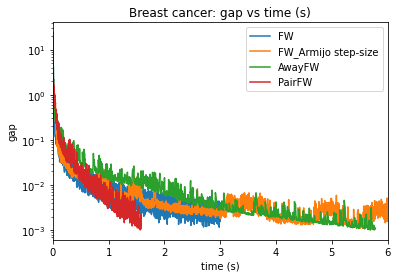

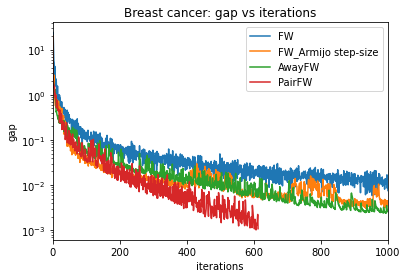

In [117]:
# Execution of the plots for the breast cancer dataset
plot_gap('time (s)', resultsDict=resultsBreastCancer, datasetName=stringBreastCancer, x_axis_limit=6)
plot_gap('iterations', resultsDict=resultsBreastCancer, datasetName=stringBreastCancer, x_axis_limit=1000)

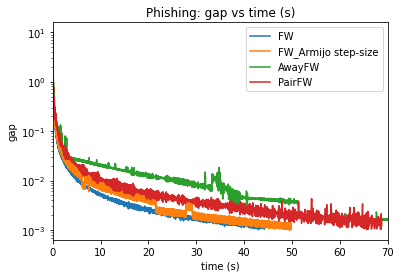

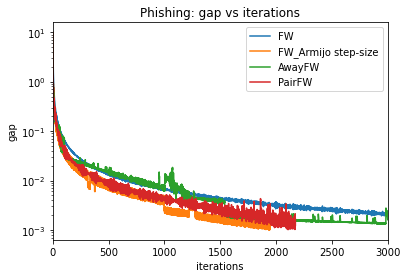

In [120]:
# Execution of the plots for the phishing dataset
plot_gap('time (s)', resultsDict=resultsPhishing, datasetName=stringPhishing, x_axis_limit=70)
plot_gap('iterations', resultsDict=resultsPhishing, datasetName=stringPhishing, x_axis_limit=3000)

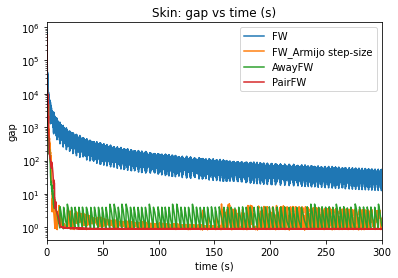

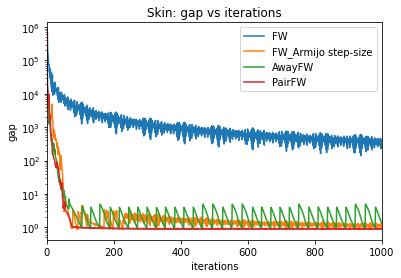

In [123]:
# Execution of the plots for the skin dataset
plot_gap('time (s)', resultsDict=resultsSkin, datasetName=stringSkin, x_axis_limit=300)
plot_gap('iterations', resultsDict=resultsSkin, datasetName=stringSkin, x_axis_limit=1000)

In [24]:
# Organizing the optimization final results (output) in tables for each dataset

# Definition of a function to organize the classification results
def optimization_results(datasetName):
    # Creating lists for each of the datasets with the accuracy and f1 scores of each method
    listMethods = ['Frank-Wolfe with DS', 'Frank-Wolfe with AR', 'Away-steps Frank-Wolfe','Pairwise Frank-Wolfe']
    if datasetName == stringBreastCancer:
        listFinalGap = [outputFW_breastCancer_DS['gap'], outputFW_breastCancer_AR['gap'], 
                        outputASFW_breastCancer['gap'], outputPairFW_breastCancer['gap']]
        listFinalObjFun = [outputFW_breastCancer_DS['objFunValue'], outputFW_breastCancer_AR['objFunValue'],
                           outputASFW_breastCancer['objFunValue'], outputPairFW_breastCancer['objFunValue']]
    elif datasetName == stringPhishing:
        listFinalGap = [outputFW_phishing_DS['gap'], outputFW_phishing_AR['gap'], 
                        outputASFW_phishing['gap'], outputPairFW_phishing['gap']]
        listFinalObjFun = [outputFW_phishing_DS['objFunValue'], outputFW_phishing_AR['objFunValue'],
                           outputASFW_phishing['objFunValue'], outputPairFW_phishing['objFunValue']]
    elif datasetName == stringSkin:
        listFinalGap = [outputFW_skin_DS['gap'], outputFW_skin_AR['gap'], 
                        outputASFW_skin['gap'], outputPairFW_skin['gap']]
        listFinalObjFun = [outputFW_skin_DS['objFunValue'], outputFW_skin_AR['objFunValue'],
                           outputASFW_skin['objFunValue'], outputPairFW_skin['objFunValue']]
    
    # Organizing the data in a dataframe and rounding the results
    optimizationResults = pd.DataFrame({'Method':listMethods,
                                         'Gap':listFinalGap,
                                         'Objective function':listFinalObjFun})
    optimizationResults = optimizationResults.round(5)
    return optimizationResults

In [25]:
# Optimization results for the breast cancer dataset
optimizationResultsBreastCancer = optimization_results(stringBreastCancer)
optimizationResultsBreastCancer

,Method,Gap,Objective function
0,Frank-Wolfe with DS,0.00099,0.01955
1,Frank-Wolfe with AR,0.00098,0.02003
2,Away-steps Frank-Wolfe,0.00096,0.01956
3,Pairwise Frank-Wolfe,0.00088,0.01955


In [26]:
# Optimization results for the phishing dataset
optimizationResultsPhishing = optimization_results(stringPhishing)
optimizationResultsPhishing

,Method,Gap,Objective function
0,Frank-Wolfe with DS,0.00099,0.00063
1,Frank-Wolfe with AR,0.00099,0.00079
2,Away-steps Frank-Wolfe,0.00100,0.00080
3,Pairwise Frank-Wolfe,0.00097,0.00077


In [27]:
# Optimization results for the skin dataset
optimizationResultsSkin = optimization_results(stringSkin)
optimizationResultsSkin

,Method,Gap,Objective function
0,Frank-Wolfe with DS,15.24507,0.05783
1,Frank-Wolfe with AR,0.89739,0.38164
2,Away-steps Frank-Wolfe,1.10145,0.40814
3,Pairwise Frank-Wolfe,0.91222,0.40437


### Saving the results

In [28]:
# Saving the results to avoid running everything again
import pandas as pd
import os

def save_results(resultsDict, title):
    for method, result in resultsDict.items():
        timeList = result[0]
        iterationsList = result[1]
        gapList = result[2]
        methodTagList = [method]*len(result[0])
        df = pd.DataFrame({method:methodTagList, 'Time':timeList, 'Iterations':iterationsList, 'Gap':gapList})

        # Get the directory path of the current Jupyter notebook
        df.to_csv(f'C:/Camilo/Estudio/Padova/Optimization for Data Science/ODS-Final-project/Output files/{title}-{method}.csv', index=False)
        np.savetxt(f'C:/Camilo/Estudio/Padova/Optimization for Data Science/ODS-Final-project/Output files/{title}-Y_pred {method}.csv', result[2], delimiter=',')
        
save_results(resultsDict=resultsBreastCancer, title='Breast cancer')
save_results(resultsDict=resultsPhishing, title='Phishing')
save_results(resultsDict=resultsSkin, title='Skin')